<a href="https://colab.research.google.com/github/Siddhu232004/GEN-AI/blob/main/GEN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
import pandas as pd

df = pd.read_csv('housing.csv')

Saving housing.csv to housing.csv


Loading California Housing dataset...

Features:
- MedInc: Median income in block group
- HouseAge: Median house age in block group
- AveRooms: Average number of rooms
- AveBedrms: Average number of bedrooms
- Population: Block group population
- AveOccup: Average occupancy
- Latitude: Block group latitude
- Longitude: Block group longitude

Dataset shape: (20640, 9)

First 5 records:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


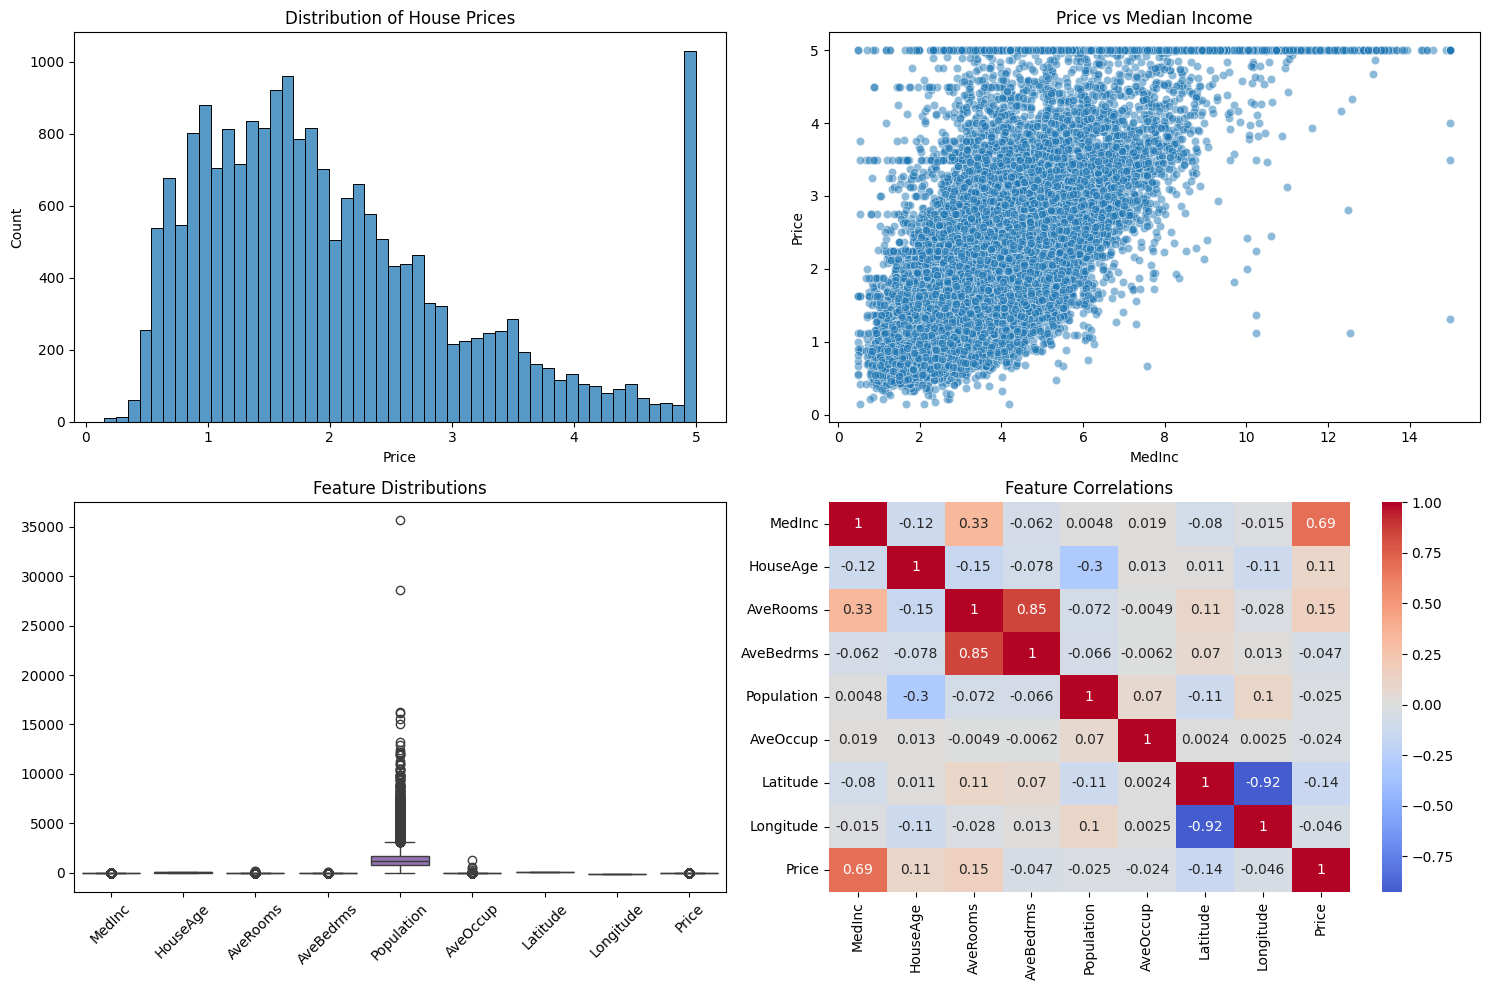


Training started...
Epoch 0/200
Training Loss: 6.5069
Validation Loss: 6.1024


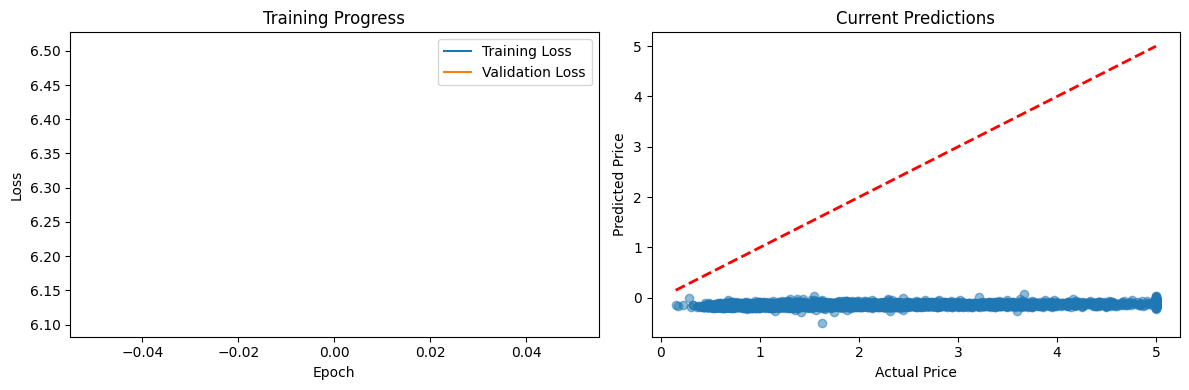

Epoch 20/200
Training Loss: 5.1921
Validation Loss: 5.2289


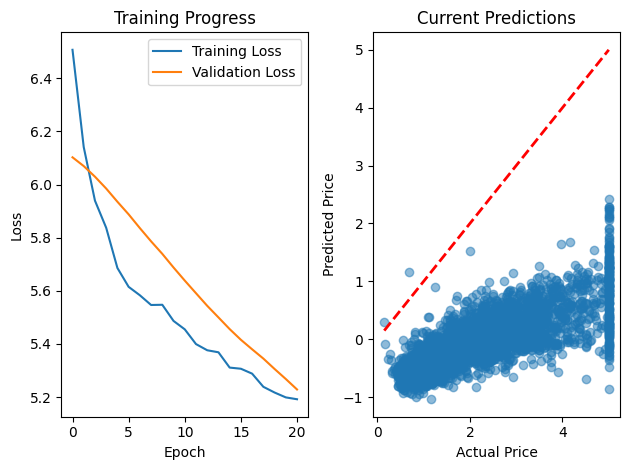

Epoch 40/200
Training Loss: 4.7538
Validation Loss: 4.7216


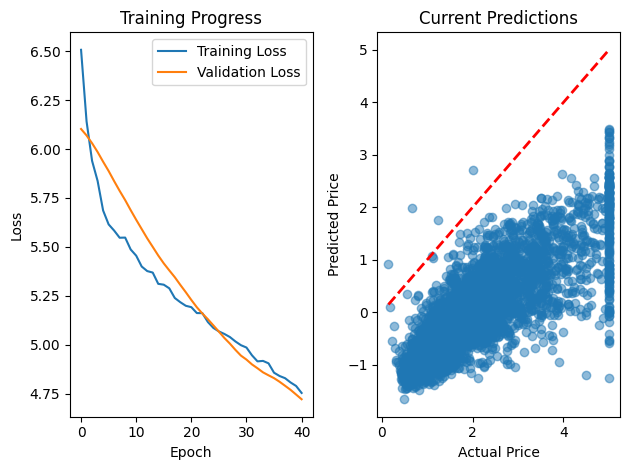

Epoch 60/200
Training Loss: 4.2690
Validation Loss: 4.2577


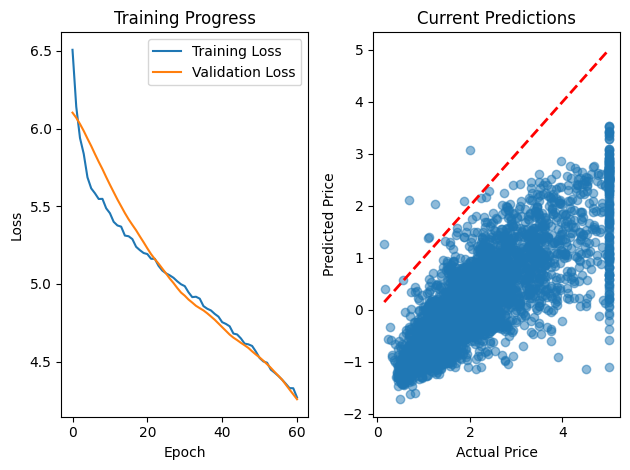

Epoch 80/200
Training Loss: 3.6740
Validation Loss: 3.5964


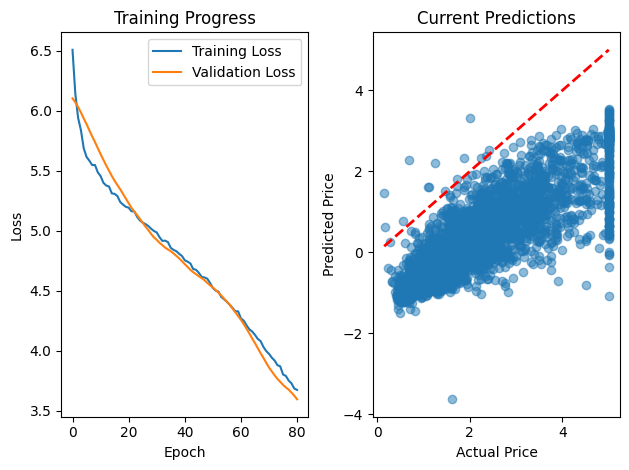

Epoch 100/200
Training Loss: 3.0121
Validation Loss: 2.8312


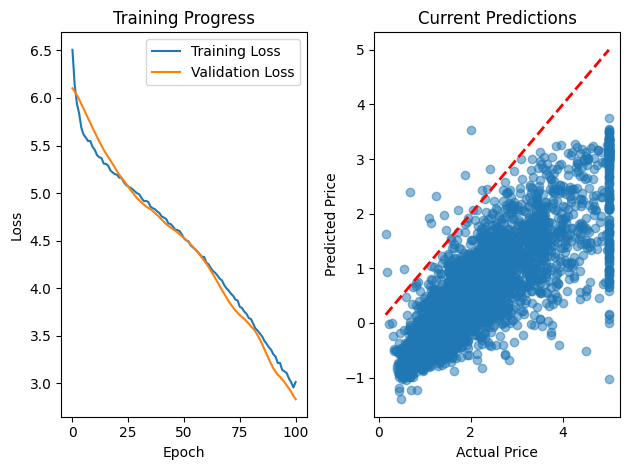

Epoch 120/200
Training Loss: 2.2779
Validation Loss: 2.0764


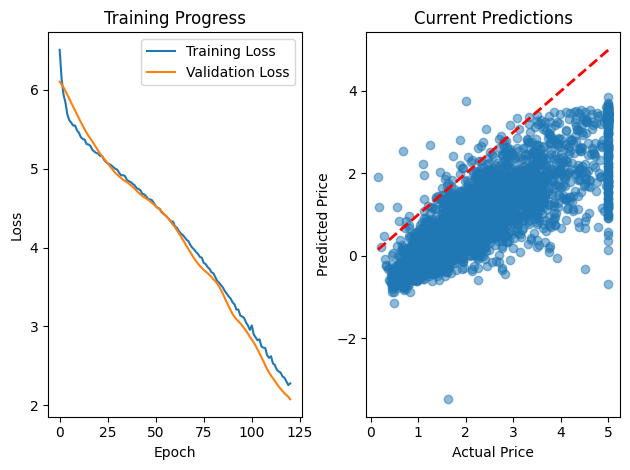

Epoch 140/200
Training Loss: 1.5888
Validation Loss: 1.4050


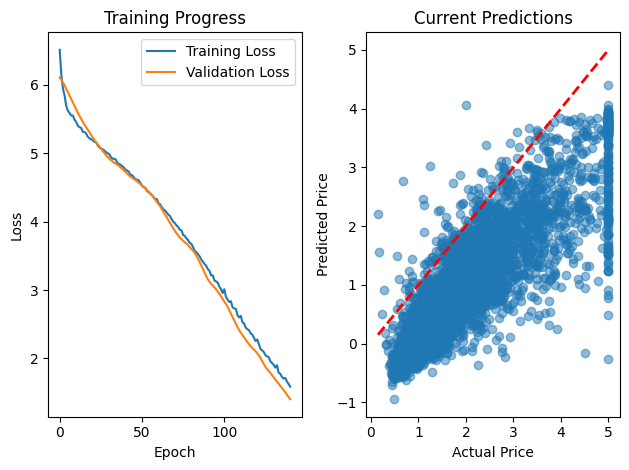

Epoch 160/200
Training Loss: 1.1153
Validation Loss: 0.8813


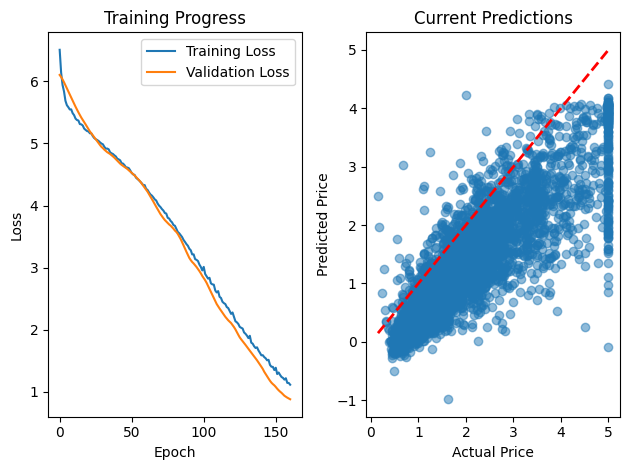

Epoch 180/200
Training Loss: 0.8220
Validation Loss: 0.6052


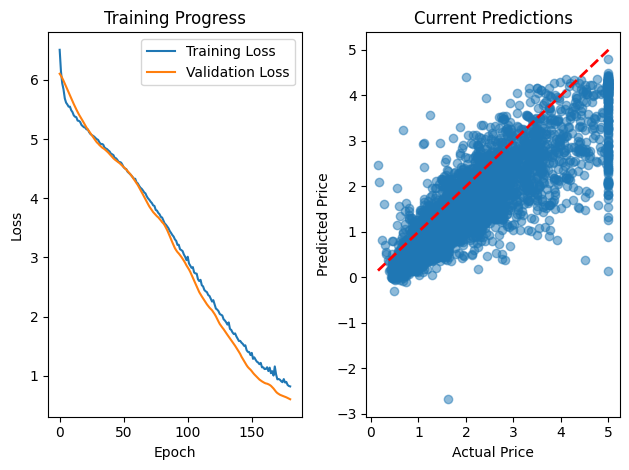


Final Model Performance:
MSE: 0.4274
RMSE: 0.6537
R² Score: 0.6739


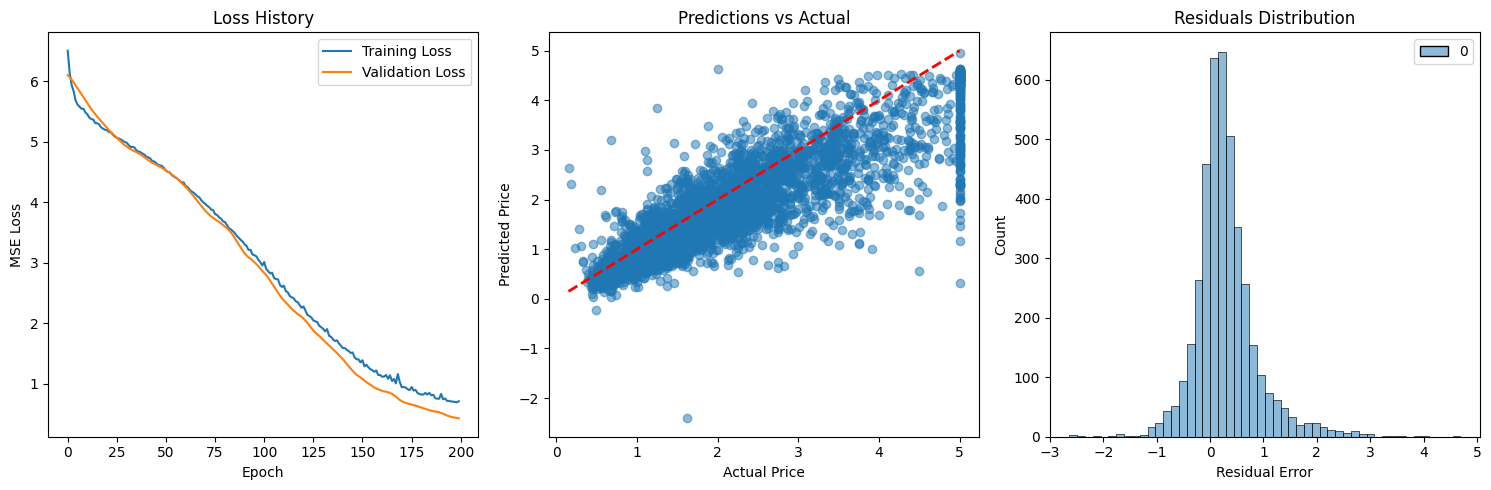

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class HousePriceDataset:
    def __init__(self):
        self.features = {
            'MedInc': 'Median income in block group',
            'HouseAge': 'Median house age in block group',
            'AveRooms': 'Average number of rooms',
            'AveBedrms': 'Average number of bedrooms',
            'Population': 'Block group population',
            'AveOccup': 'Average occupancy',
            'Latitude': 'Block group latitude',
            'Longitude': 'Block group longitude'
        }
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        print("Loading California Housing dataset...")
        housing = fetch_california_housing()
        self.data = pd.DataFrame(housing.data, columns=housing.feature_names)
        self.data['Price'] = housing.target
        self._print_info()
        self._plot_data_insights()
        return self.data

    def _print_info(self):
        print("\nFeatures:")
        for name, desc in self.features.items():
            print(f"- {name}: {desc}")
        print(f"\nDataset shape: {self.data.shape}")
        print("\nFirst 5 records:")
        print(self.data.head())

    def _plot_data_insights(self):
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        sns.histplot(self.data['Price'], bins=50)
        plt.title('Distribution of House Prices')
        plt.xlabel('Price')

        plt.subplot(2, 2, 2)
        sns.scatterplot(data=self.data, x='MedInc', y='Price', alpha=0.5)
        plt.title('Price vs Median Income')

        plt.subplot(2, 2, 3)
        sns.boxplot(data=self.data)
        plt.xticks(rotation=45)
        plt.title('Feature Distributions')

        plt.subplot(2, 2, 4)
        sns.heatmap(self.data.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlations')

        plt.tight_layout()
        plt.show()

    def prepare_data(self, test_size=0.2):
        X = self.data.drop('Price', axis=1).values
        y = self.data['Price'].values.reshape(-1, 1)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=42
        )

        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.y_train = torch.FloatTensor(y_train)
        self.y_test = torch.FloatTensor(y_test)

        return self.X_train, self.X_test, self.y_train, self.y_test

class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class Trainer:
    def __init__(self, model, criterion=nn.MSELoss(), learning_rate=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.losses = []
        self.val_losses = []

    def train(self, X_train, y_train, X_test, y_test, epochs=200):
        print("\nTraining started...")
        plt.figure(figsize=(12, 4))
        plt.ion()

        for epoch in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()

            train_pred = self.model(X_train)
            train_loss = self.criterion(train_pred, y_train)

            train_loss.backward()
            self.optimizer.step()

            with torch.no_grad():
                self.model.eval()
                val_pred = self.model(X_test)
                val_loss = self.criterion(val_pred, y_test)

            self.losses.append(train_loss.item())
            self.val_losses.append(val_loss.item())

            if epoch % 20 == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"Training Loss: {train_loss.item():.4f}")
                print(f"Validation Loss: {val_loss.item():.4f}")

                plt.clf()
                plt.subplot(1, 2, 1)
                plt.plot(self.losses, label='Training Loss')
                plt.plot(self.val_losses, label='Validation Loss')
                plt.title('Training Progress')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.scatter(y_test.numpy(), val_pred.numpy(), alpha=0.5)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
                plt.title('Current Predictions')
                plt.xlabel('Actual Price')
                plt.ylabel('Predicted Price')

                plt.tight_layout()
                plt.pause(0.1)

        plt.ioff()
        plt.show()

    def evaluate(self, X_test, y_test):
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_test)
            mse = self.criterion(predictions, y_test).item()
            rmse = np.sqrt(mse)
            r2 = 1 - ((y_test - predictions) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

        print("\nFinal Model Performance:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2.item():.4f}")

        return predictions.numpy(), mse, rmse, r2.item()

    def plot_final_results(self, y_test, predictions):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.scatter(y_test, predictions, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title('Predictions vs Actual')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')

        plt.subplot(1, 3, 3)
        residuals = y_test - predictions
        sns.histplot(residuals, bins=50)
        plt.title('Residuals Distribution')
        plt.xlabel('Residual Error')

        plt.tight_layout()
        plt.show()

def main():
    torch.manual_seed(42)
    np.random.seed(42)

    dataset = HousePriceDataset()
    dataset.load_data()
    X_train, X_test, y_train, y_test = dataset.prepare_data()

    model = HousePriceModel(X_train.shape[1])
    trainer = Trainer(model)

    trainer.train(X_train, y_train, X_test, y_test)
    predictions, mse, rmse, r2 = trainer.evaluate(X_test, y_test)
    trainer.plot_final_results(y_test.numpy(), predictions)

if __name__ == "__main__":
    main()
